In [1]:
# the default directory is the "notebooks" folder; set it one level up.
setwd("..")

In [38]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [62]:
library(readr)
library(dplyr)
library(tidyr)
library(purrr)
library(tibble)
library(ggplot2)
library(ggthemes)
library(ggpubr)

## Read in `sourmash taxonomy` results

In [5]:
read_gather <- function(path){
  gather <- read_csv(path, col_types = "ddddddddcccddddcccdc")
}

In [45]:
sourmash_taxonomy <- Sys.glob("outputs/sourmash_taxonomy/*k31*csv") %>%
  map_dfr(read_gather) %>% # read in files
  separate(lineage, into = c("kingdom", "phylum", "class", "order", "family", "genus", "species", "strain"),
           sep = ";", remove = F, fill = "right") %>% # separate lineage column into commensurate parts
  mutate(database = basename(filename),
         database = gsub("genbank-2022.03-", "", database),
         database = gsub("-k31.zip", "", database))

## Sample composition overview

#### How many total genomes (strains) were detected in each metagenome?

In [15]:
sourmash_taxonomy %>%
  group_by(query_name) %>%
  tally()

query_name,n
<chr>,<int>
SRR19888423,796
SRR19888427,827
SRR19888432,970
SRR19888434,1034
SRR19888438,773
SRR19888440,950


#### How many total species were detected in each metagenome?

In [22]:
sourmash_taxonomy %>%
  select(lineage, query_name) %>%
  distinct() %>%
  group_by(query_name) %>%
  tally()

query_name,n
<chr>,<int>
SRR19888423,652
SRR19888427,634
SRR19888432,833
SRR19888434,853
SRR19888438,626
SRR19888440,736


#### How many total genomes (strains) were detected among the metagenomes for each of the five lineages bacteria, archaea, viral, protozoa, fungi?

In [46]:
sourmash_taxonomy %>%
  group_by(database, query_name) %>%
  tally()

database,query_name,n
<chr>,<chr>,<int>
archaea,SRR19888432,2
archaea,SRR19888434,1
archaea,SRR19888440,2
bacteria,SRR19888423,787
bacteria,SRR19888427,810
bacteria,SRR19888432,958
bacteria,SRR19888434,1016
bacteria,SRR19888438,761
bacteria,SRR19888440,927


In [21]:
sourmash_taxonomy %>%
  select(lineage) %>%
  distinct() %>%
  nrow()

[1] 1725

## plot something

In [73]:
bacteria_plot <- ggplot(sourmash_taxonomy %>% filter(database == "bacteria"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_tableau(palette = "Tableau 20")

fungi_plot <- ggplot(sourmash_taxonomy %>% filter(database == "fungi"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Set1")

viral_plot <- ggplot(sourmash_taxonomy %>% filter(database == "viral"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Set2")

protozoa_plot <- ggplot(sourmash_taxonomy %>% filter(database == "protozoa"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_brewer(palette = "Dark2")

archaea_plot <- ggplot(sourmash_taxonomy %>% filter(database == "archaea"), aes(x = query_name, y = f_unique_weighted, fill = phylum)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~database, scales = "free_x") +
  theme_classic() +
  scale_fill_tableau(palette = "Tableau 10")

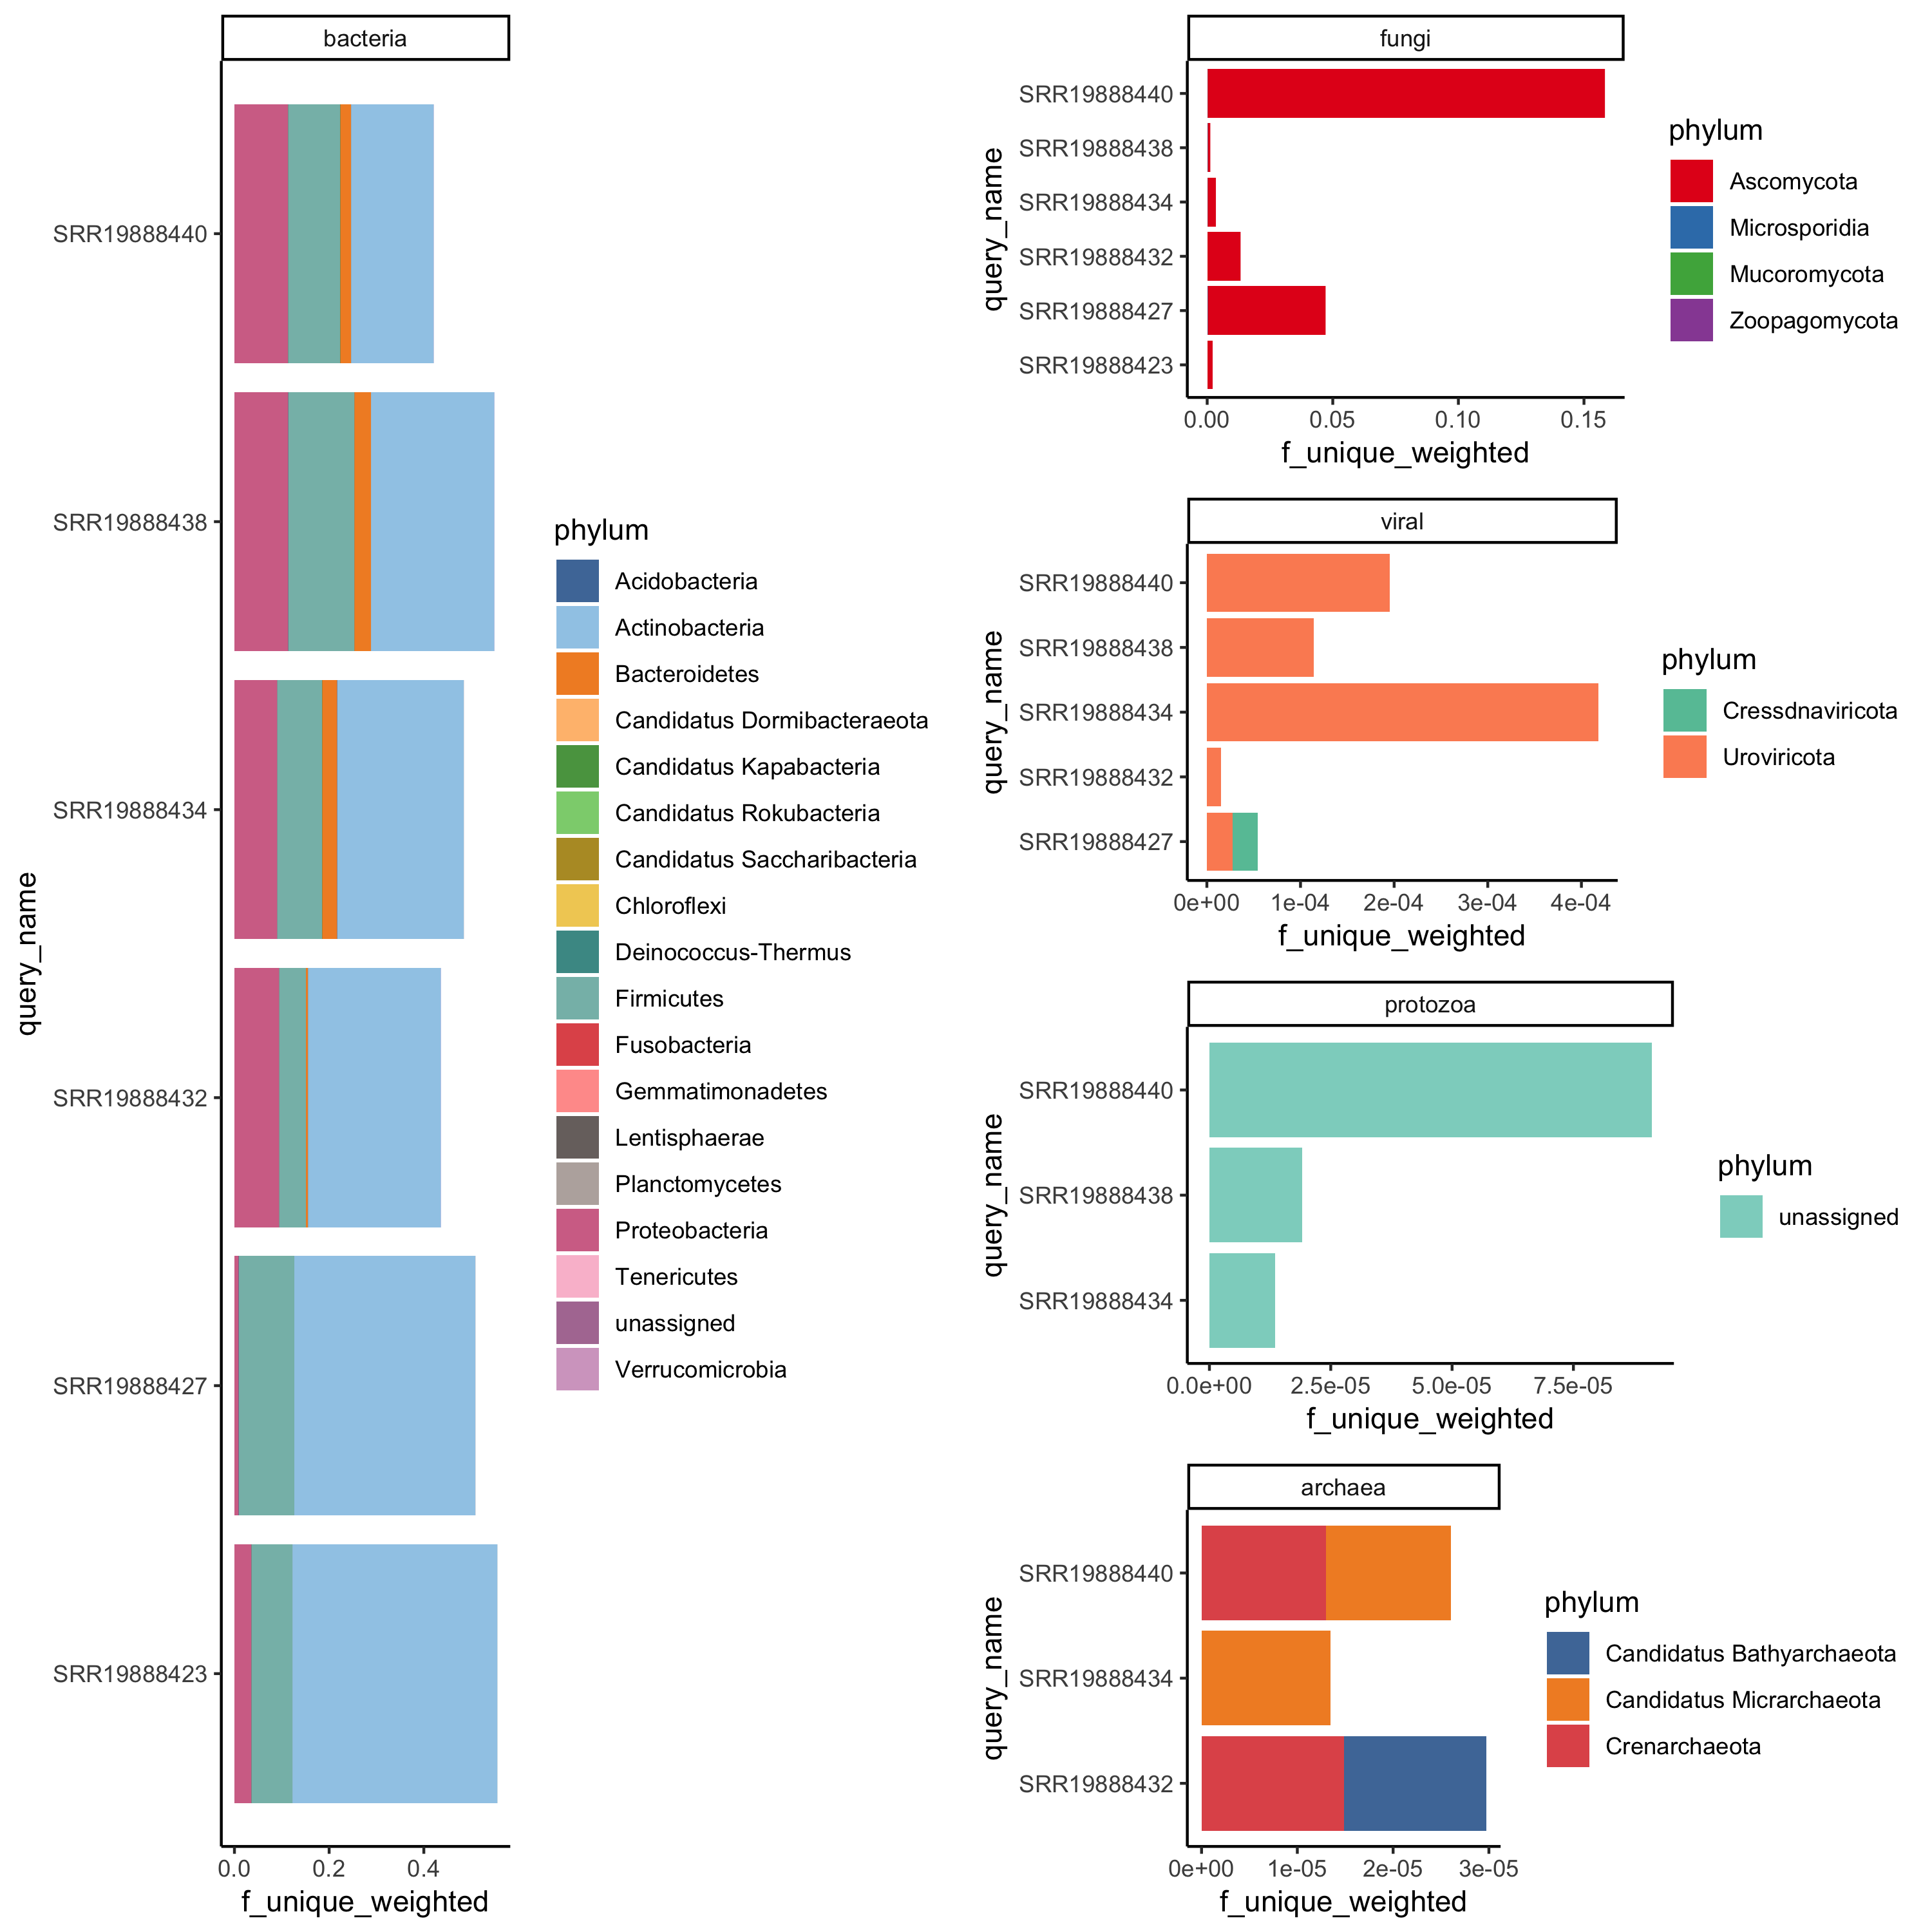

In [72]:
ggarrange(bacteria_plot, 
          ggarrange(fungi_plot, viral_plot, protozoa_plot, archaea_plot, nrow =4, ncol = 1), ncol = 2)